In [1]:
#1
import pandas as pd
import numpy as np
import json

import psycopg2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn import metrics
from xgboost import plot_importance
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor   
import seaborn as sns
%matplotlib inline
import pickle
import gc
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
plt.style.use('bmh')
from pandas import Series, DataFrame
from sklearn.model_selection import GridSearchCV

import traceback
import sys
import os

import re
import datetime
datetime.timedelta()
import pickle

/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


## Loading Required Data Files

In [2]:
#fetching existing raw data (allocation / comms)

x=10

existing_comms=pd.read_csv("../existing_raw_data/existing_comms.csv")
allocation=pd.read_csv('../existing_raw_data/allocation_set_A.csv')
allocation_B=pd.read_csv('../existing_raw_data/allocation_set_B.csv')
agent_disp_1_2=pd.read_csv('../existing_raw_data/AGENT_DISP_1_2.csv')
S_AMT=pd.read_excel('../existing_raw_data/S_AMT.xlsx')
file_name = "../existing_raw_data/xgb_model.pkl"

existing_comms.shape
allocation.shape

#fetching new comms data:
new_comms=pd.read_csv('../new_raw_data/new_comms.csv')
paid_file=pd.read_excel('../new_raw_data/paid_file.xlsx')


new_comms.shape
paid_file.shape

#merging new_comms with existing_comms:
existing_comms=pd.concat([existing_comms,new_comms])

existing_comms.shape

#saving files back to existing raw data
#existing_comms.to_csv('../existing_raw_data/existing_comms.csv')
#paid_file.to_csv('../existing_raw_data/paid_file.csv')


#Changing in SOME FILES:
#paid_file=pd.read_excel('RR_aug_paidfile_1_11_v1.xlsx')
paid_file=paid_file.rename(columns={'Date':'Date Repaid','Laon_ID':'Loan_ID','Loan No':'Loan_ID'})
existing_comms['Loan_ID']=existing_comms['Loan_ID'].fillna(0)

#os.remove('../new_raw_data/new_comms.csv')
#os.remove('../new_raw_data/new_paid_file.csv')

(966294, 36)

(22245, 39)

(198704, 36)

(2758, 6)

(1164998, 36)

## Creation of model_data

In [3]:
%run /home/recovery_prediction/pod5_recovery_prediction/praveen/Projects/RR/intent_to_pay_v1/codes/intermediate_codes/data_creation_for_modeling.ipynb

print('COMMS_1_2_PICKED')
comms_1_2_picked=comms_1_2_picked_customers_script_4(allocation.copy(),existing_comms.copy())
comms_1_2_picked.shape

print('SCRIPT_1')
ST1=overall_comms_features_script_1(allocation.copy(),existing_comms.copy(),comms_1_2_picked.copy())
ST1.shape

print('SCRIPT_2')
ST2=last_3_comms_features_script_2(allocation.copy(),existing_comms.copy(),comms_1_2_picked.copy(),agent_disp_1_2.copy())
ST2.shape

print('SCRIPT_3')
ST3=loan_data_features_script_3(allocation.copy(),existing_comms.copy(),comms_1_2_picked.copy(),agent_disp_1_2.copy())
ST3.shape


COMMS_1_2_PICKED


(645, 42)

SCRIPT_1


(21956, 9)

SCRIPT_2


(21956, 174)

SCRIPT_3


(21956, 10)

## Fetching Model Results

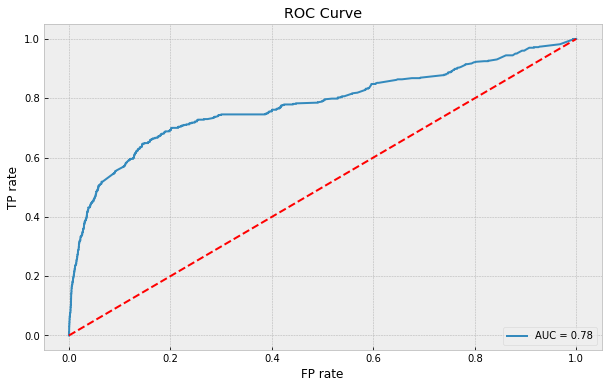

Results on top 1% data : 
precision :  39.09090909090909
recall :  16.962524654832347 

Results on top 5% data : 
precision :  19.94535519125683
recall :  43.19526627218935 

Results on top 10% data : 
precision :  12.659380692167577
recall :  54.83234714003945 

Results on top 30% data : 
precision :  5.677850311219068
recall :  73.76725838264299 



In [4]:
%run /home/recovery_prediction/pod5_recovery_prediction/praveen/Projects/RR/intent_to_pay_v1/codes/intermediate_codes/model_results.ipynb

xgb_model= pickle.load(open(file_name, "rb"))

#Creation of risk segment
risk_segment=model_results(xgb_model,ST1.copy(),ST2.copy(),ST3.copy(),paid_file.copy(),allocation.copy(),existing_comms.copy())


## Creation of 3 result files:

#### 1. risk segment file to send 
#### 2. risk segment file for internal analysis
#### 3. SET-A  / SET-B overall analysis  file





In [5]:
%run /home/recovery_prediction/pod5_recovery_prediction/praveen/Projects/RR/intent_to_pay_v1/codes/intermediate_codes/fetching_final_tablular_resutls.ipynb
#risk_segment =pd.read_csv('..//existing_raw_data/risk_segment.csv')

risk_segment.shape

#Result_1 #Result_2
risk_segment_file_to_send,risk_segment_file_to_internal=func1(risk_segment,allocation,existing_comms,paid_file,S_AMT)
risk_segment_file_to_send.shape
risk_segment_file_to_internal.shape

risk_segment_file_to_send.to_csv('..//output_files/RR_ITP_jul_risk_segment_results_to_send.csv',index=False)
risk_segment_file_to_internal.to_csv('..//output_files/RR_ITP_jul_risk_segment_results_to_internal.csv',index=False)

#Result_3/ Result_4

existing_comms.shape
SET_A_overall_analysis=func2(risk_segment,allocation,existing_comms,paid_file)
SET_B_overall_analysis=func2(risk_segment,allocation_B,existing_comms,paid_file)

SET_A_overall_analysis['SET']='SET-A'
SET_B_overall_analysis['SET']='SET-B'

SET_A_B_overall_analysis=pd.concat([SET_A_overall_analysis,SET_B_overall_analysis])
#SET_A_B_overall_analysis.insert(0, 'SET')

# shift column 'Name' to first position
first_column = SET_A_B_overall_analysis.pop('SET')
  
# insert column using insert(position,column_name,
# first_column) function
SET_A_B_overall_analysis.insert(0, 'SET', first_column)

SET_A_B_overall_analysis.shape

SET_A_B_overall_analysis.to_csv('..//output_files/SET_A_B_overall_analysis.csv',index=False)


(22245, 8)

(22245, 8)


(22245, 14)

(22245, 22)

(1164998, 39)

(4, 10)

## Results to show

In [6]:
risk_segment_rate=risk_segment_file_to_send.groupby('risk_segment').agg(customer_count=('AgreementNumber','count'),paid_customers=('paid_flag','sum')).reset_index()                                                                         
                                                                          

In [7]:
#risk_segment_rate
risk_segment_rate['rank']=[3,1,2,4]
risk_segment_rate=risk_segment_rate.sort_values('rank')
risk_segment_rate.drop('rank',axis=1,inplace=True)


risk_segment_rate['paid_rate']=round(risk_segment_rate['paid_customers']/risk_segment_rate['customer_count']*100,2)
risk_segment_rate['distribution_%']=round((risk_segment_rate['customer_count']/risk_segment_rate['customer_count'].sum())*100,2)
risk_segment_rate


,risk_segment,customer_count,paid_customers,paid_rate,distribution_%
1,low_risk,825,188.0,22.79,3.71
2,medium_risk,3601,161.0,4.47,16.19
0,high_risk,17530,158.0,0.90,78.80
3,no_risk,289,39.0,13.49,1.30


In [8]:
SET_A_B_overall_analysis

,SET,picked_flag,comms_count,cust_count,paid_count,paid_amount,total_time_spent,churn_per_paid_cust,paid_dist,paid_rate
0,SET-A,0,145821.0,14511,173.0,681043.10,0.0,842.9,31.68,1.19
1,SET-A,1,120735.0,7734,373.0,1417116.83,2219877.0,323.7,68.32,4.82
0,SET-B,0,125669.0,14911,189.0,824129.20,0.0,664.9,31.76,1.27
1,SET-B,1,113734.0,7349,406.0,1473405.06,2145835.0,280.1,68.24,5.52


In [9]:
# #saving overall analysis to create the plots:
# if x==10:
#     SET_A_B_overall_analysis['DAY']=10
#     SET_A_B_overall_analysis.to_csv('../existing_raw_data/plots_data.csv')
# else:
#     SET_A_B_overall_analysis['DAY']=x
#     past_temp=pd.read_csv('../existing_raw_data/plots_data.csv')
#     temp=pd.concat([past_temp,SET_A_B_overall_analysis])
#     temp.to_csv('../existing_raw_data/plots_data.csv')

## Overall Status of picked and non-picked customers (SET-A)

### Picked Customers 

Plot1: SET-A-Picked Call Count
Plot2: SET-A-Picked Customers Count
Plot3: SET-A-Picked Paid Count
Plot4: SET-A-Picked paid Amount


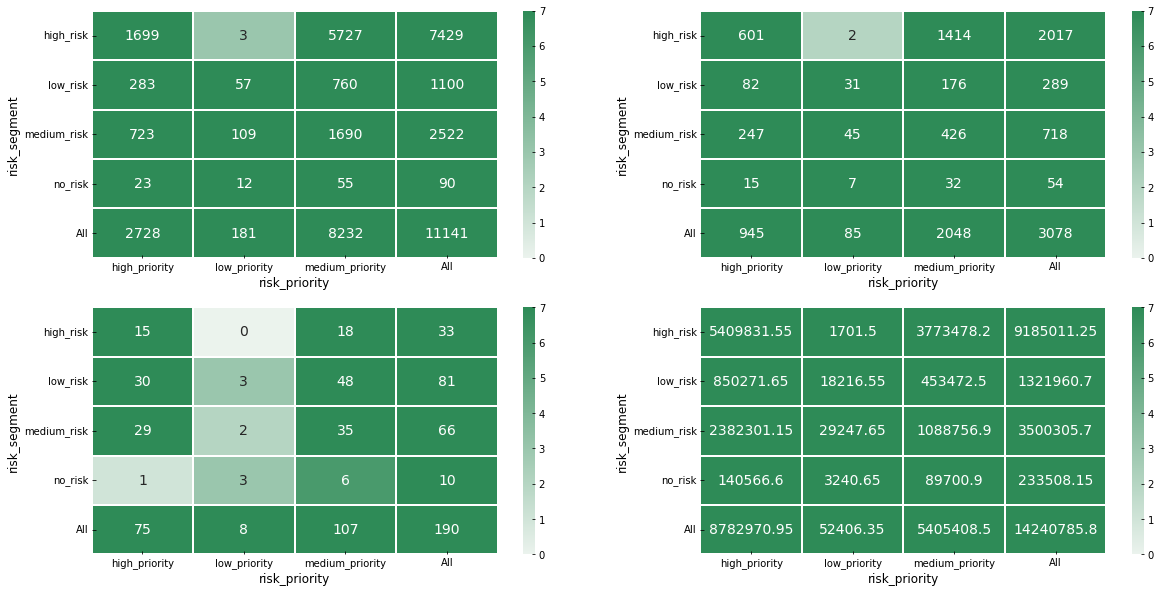

In [10]:
%run /home/recovery_prediction/pod5_recovery_prediction/praveen/Projects/RR/intent_to_pay_v1/codes/intermediate_codes/fetching_final_tablular_resutls.ipynb

risk_segment_file_to_internal['flag']=1
risk_segment_file_to_internal_picked=risk_segment_file_to_internal[risk_segment_file_to_internal['total_call_picked']>0]
tag=['Plot1: SET-A-Picked Call Count','Plot2: SET-A-Picked Customers Count','Plot3: SET-A-Picked Paid Count','Plot4: SET-A-Picked paid Amount']
func3(risk_segment_file_to_internal_picked,tag)


### Non-Picked Customers

Plot1: SET-A-Non-Picked Call Count
PLot2: SET-A-Non-Picked Customers Count
Plot3: SET-A-Non-Picked Paid Count
Plot4: SET-A-Non-Picked paid Amount


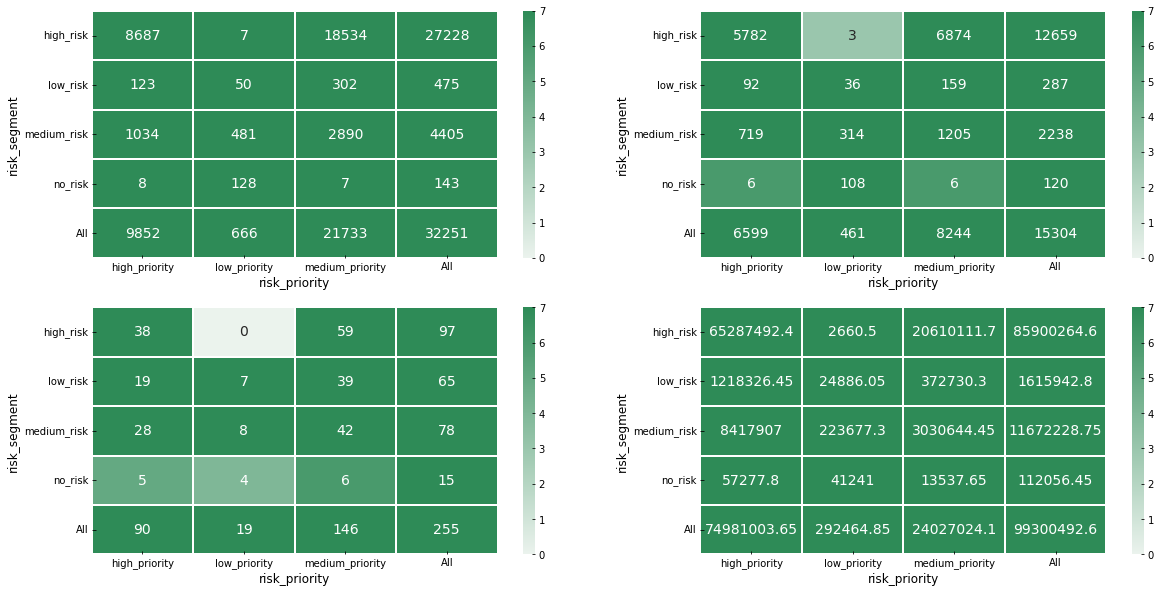

In [11]:
%run /home/recovery_prediction/pod5_recovery_prediction/praveen/Projects/RR/intent_to_pay_v1/codes/intermediate_codes/fetching_final_tablular_resutls.ipynb

risk_segment_file_to_internal['flag']=1
risk_segment_file_to_internal_non_picked=risk_segment_file_to_internal[risk_segment_file_to_internal['total_call_picked']==0]
tag=['Plot1: SET-A-Non-Picked Call Count','PLot2: SET-A-Non-Picked Customers Count','Plot3: SET-A-Non-Picked Paid Count','Plot4: SET-A-Non-Picked paid Amount']
func3(risk_segment_file_to_internal_non_picked,tag)


## Calculating Rsults for Set-B

In [12]:
existing_comms=pd.read_csv("../existing_raw_data/existing_comms.csv")
allocation=pd.read_csv('../existing_raw_data/allocation_set_A.csv')
allocation_B=pd.read_csv('../existing_raw_data/allocation_set_B.csv')
agent_disp_1_2=pd.read_csv('../existing_raw_data/AGENT_DISP_1_2.csv')
S_AMT=pd.read_excel('../existing_raw_data/S_AMT.xlsx')
file_name = "../existing_raw_data/xgb_model.pkl"
allocation_B.shape
existing_comms.shape

(22260, 39)

(966294, 36)

In [13]:
#Creation of model_data
%run /home/recovery_prediction/pod5_recovery_prediction/praveen/Projects/RR/intent_to_pay_v1/codes/intermediate_codes/data_creation_for_modeling.ipynb

print('COMMS_1_2_PICKED')
comms_1_2_picked=comms_1_2_picked_customers_script_4(allocation_B.copy(),existing_comms.copy())
comms_1_2_picked.shape

print('SCRIPT_1')
ST1=overall_comms_features_script_1(allocation_B.copy(),existing_comms.copy(),comms_1_2_picked.copy())
ST1.shape

print('SCRIPT_2')
ST2=last_3_comms_features_script_2(allocation_B.copy(),existing_comms.copy(),comms_1_2_picked.copy(),agent_disp_1_2.copy())
ST2.shape

print('SCRIPT_3')
ST3=loan_data_features_script_3(allocation_B.copy(),existing_comms.copy(),comms_1_2_picked.copy(),agent_disp_1_2.copy())
ST3.shape


COMMS_1_2_PICKED


(666, 42)

SCRIPT_1


(21538, 9)

SCRIPT_2


(21538, 174)

SCRIPT_3


(21538, 10)

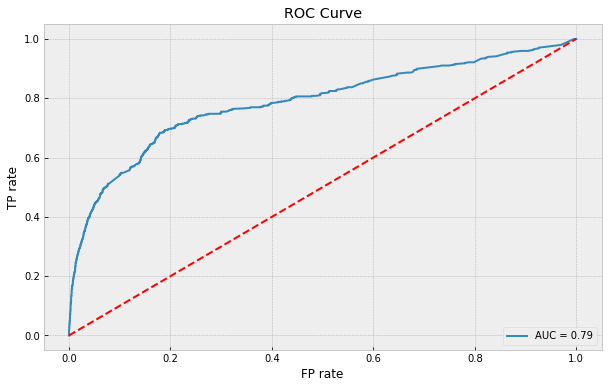

Results on top 1% data : 
precision :  41.2037037037037
recall :  16.270566727605118 

Results on top 5% data : 
precision :  20.51996285979573
recall :  40.40219378427788 

Results on top 10% data : 
precision :  13.231197771587745
recall :  52.10237659963437 

Results on top 30% data : 
precision :  6.329309811203962
recall :  74.77148080438756 



In [14]:
%run /home/recovery_prediction/pod5_recovery_prediction/praveen/Projects/RR/intent_to_pay_v1/codes/intermediate_codes/model_results.ipynb

xgb_model= pickle.load(open(file_name, "rb"))

#Creation of risk segment
risk_segment=model_results(xgb_model,ST1.copy(),ST2.copy(),ST3.copy(),paid_file.copy(),allocation_B.copy(),existing_comms.copy())


In [15]:
%run /home/recovery_prediction/pod5_recovery_prediction/praveen/Projects/RR/intent_to_pay_v1/codes/intermediate_codes/fetching_final_tablular_resutls.ipynb
#risk_segment =pd.read_csv('..//existing_raw_data/risk_segment.csv')

risk_segment.shape

#Result_1 #Result_2
risk_segment_file_to_send_B,risk_segment_file_to_internal_B=func1(risk_segment,allocation_B,existing_comms,paid_file,S_AMT)
risk_segment_file_to_send_B.shape
risk_segment_file_to_internal_B.shape
risk_segment_file_to_send_B.to_csv('..//output_files/RR_ITP_jul_set_B_risk_segment_results_to_send.csv',index=False)
risk_segment_file_to_internal_B.to_csv('..//output_files/RR_ITP_jul_set_B_risk_segment_results_to_internal.csv',index=False)


(22260, 8)

(22260, 8)


(22260, 14)

(22260, 22)

In [16]:
risk_segment_rate=risk_segment_file_to_send_B.groupby('risk_segment').agg(customer_count=('AgreementNumber','count'),paid_customers=('paid_flag','sum')).reset_index()                                                                         
                                                                          

#risk_segment_rate
risk_segment_rate['rank']=[3,1,2,4]
risk_segment_rate=risk_segment_rate.sort_values('rank')
risk_segment_rate.drop('rank',axis=1,inplace=True)


risk_segment_rate['paid_rate']=round(risk_segment_rate['paid_customers']/risk_segment_rate['customer_count']*100,2)

risk_segment_rate['distribution_%']=round((risk_segment_rate['customer_count']/risk_segment_rate['customer_count'].sum())*100,2)

risk_segment_rate


,risk_segment,customer_count,paid_customers,paid_rate,distribution_%
1,low_risk,1037,218.0,21.02,4.66
2,medium_risk,3620,164.0,4.53,16.26
0,high_risk,16881,165.0,0.98,75.84
3,no_risk,722,48.0,6.65,3.24


## Overall Status of picked and non-picked customers (SET-B)

### Picked Customers 

Plot1: SET-B-Picked Call Count
Plot2: SET-B-Picked Customers Count
Plot3: SET-B-Picked Paid Count
Plot4: SET-B-Picked paid Amount


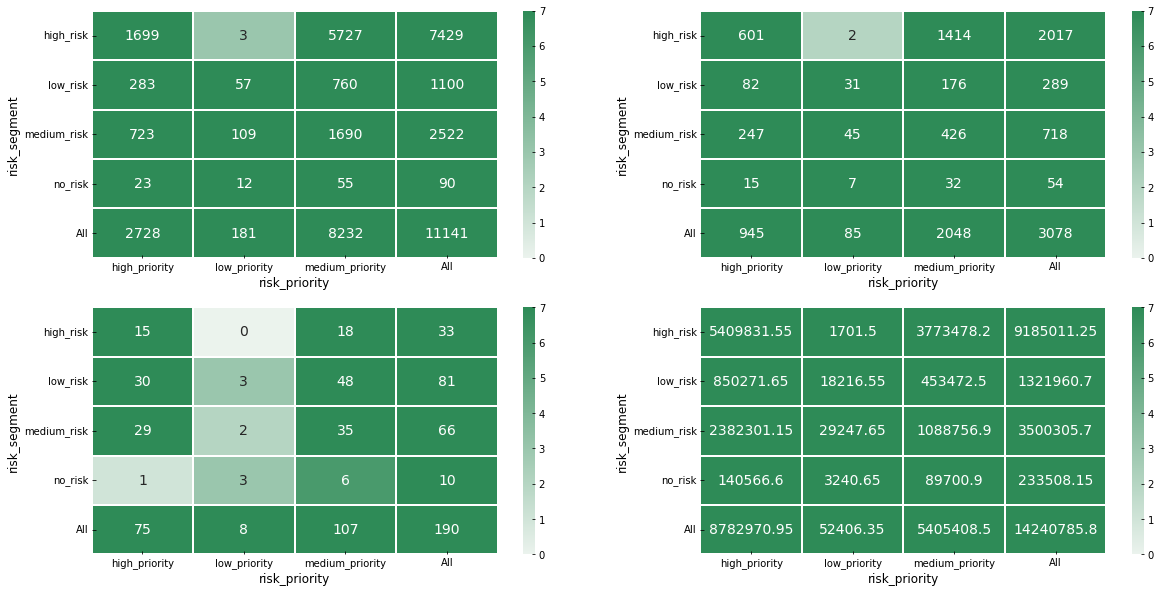

In [17]:
%run /home/recovery_prediction/pod5_recovery_prediction/praveen/Projects/RR/intent_to_pay_v1/codes/intermediate_codes/fetching_final_tablular_resutls.ipynb

risk_segment_file_to_internal_B['flag']=1
risk_segment_file_to_internal_B_picked=risk_segment_file_to_internal_B[risk_segment_file_to_internal_B['total_call_picked']>0]
tag=['Plot1: SET-B-Picked Call Count','Plot2: SET-B-Picked Customers Count','Plot3: SET-B-Picked Paid Count','Plot4: SET-B-Picked paid Amount']
func3(risk_segment_file_to_internal_picked,tag)


### Non-Picked Customers

Plot1: SET-B-Non-Picked Call Count
Plot2: SET-B-Non-Picked Customers Count
Plot3: SET-B-Non-Picked Paid Count
Plot4: SET-B-Non-Picked paid Amount


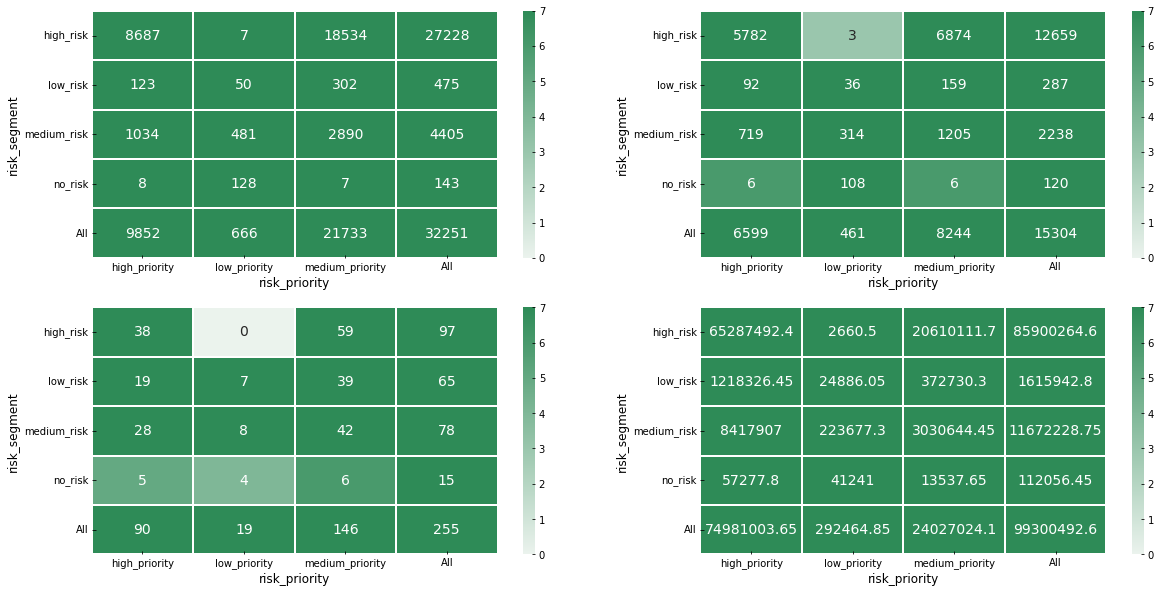

In [18]:
%run /home/recovery_prediction/pod5_recovery_prediction/praveen/Projects/RR/intent_to_pay_v1/codes/intermediate_codes/fetching_final_tablular_resutls.ipynb

risk_segment_file_to_internal_B['flag']=1
risk_segment_file_to_internal_B_non_picked=risk_segment_file_to_internal_B[risk_segment_file_to_internal_B['total_call_picked']==0]
tag=['Plot1: SET-B-Non-Picked Call Count','Plot2: SET-B-Non-Picked Customers Count','Plot3: SET-B-Non-Picked Paid Count','Plot4: SET-B-Non-Picked paid Amount']

func3(risk_segment_file_to_internal_non_picked,tag)


## Creation of daily plots:


In [144]:
plots_data=pd.read_csv("../existing_raw_data/plots_data.csv")
daily_plots_picked=plots_data[plots_data.picked_flag==1]

In [146]:
%run /home/recovery_prediction/pod5_recovery_prediction/praveen/Projects/RR/intent_to_pay_v1/codes/intermediate_codes/daily_plots.ipynb


#### Paid Count

In [ ]:
date="date"
plot_type='paid_count'
plots_creation(date,plot_type,daily_plots_picked)

#### Paid Amount

In [ ]:
date="date"
plot_type='paid_amount'
plots_creation(date,plot_type,daily_plots_picked)

#### comms_count 

In [ ]:
date="date"
plot_type='comms_count'
plots_creation(date,plot_type,daily_plots_picked)

#### cust_count 

In [ ]:
date="date"
plot_type='cust_count'
plots_creation(date,plot_type,daily_plots_picked)

#### Total Time Spent 

In [ ]:
date="date"
plot_type='total_time_spent'
plots_creation(date,plot_type,daily_plots_picked)

#### churn_per_paid_cust

In [ ]:
date="date"
plot_type='churn_per_paid_cust'
plots_creation(date,plot_type,daily_plots_picked)